In [1]:
import numpy as np
#from netCDF4 import Dataset as ncdset
import glob
import warnings
import datetime
import scipy.stats
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import os
import cdsapi
#from scipy.optimize import curve_fit
import xarray as xr
import xskillscore as xs
import pandas as pd
import xesmf as xesmf
import operator

In [2]:
def global_average(dataArray,latstr,lonstr):
    #Compute the latitude weighted average over the PNW
    #datout = dataArray.where((dataArray[latstr] > 40.5) & (dataArray[latstr] < 50.5) &
    #                        (dataArray[lonstr] > 235.5) & (dataArray[lonstr] < 253.5),drop=True)
    weights = np.cos(np.deg2rad(dataArray[latstr]))
    weights.name = 'weights'
    datout_weighted = dataArray.weighted(weights).mean(dim=[latstr,lonstr],skipna=True)
    return datout_weighted

In [3]:
def coordnames(nci):
    if 'latitude' in list(nci.variables):
        latstr = 'latitude'
    elif 'lat' in list(nci.variables):
        latstr = 'lat'
    elif 'nav_lat' in list(nci.variables):
        latstr = 'nav_lat'

    if 'longitude' in list(nci.variables):
        lonstr = 'longitude'
    elif 'lon' in list(nci.variables):
        lonstr = 'lon'
    elif 'nav_lon' in list(nci.variables):
        lonstr = 'nav_lon'

    if 'lat' in list(nci.dims):
        latdim = 'lat'
        londim = 'lon'
    elif 'latitude' in list(nci.dims):
        latdim = 'latitude'
        londim = 'longitude'
    elif 'nav_lat' in list(nci.dims):
        latdim = 'nav_lat'
        londim = 'nav_lon'
    elif 'x' in list(nci.dims):
        latdim = 'y'
        londim = 'x'
    else:
        latdim = 'j'
        londim = 'i'
    return latstr,lonstr,latdim,londim

In [4]:
def fixlons(nci,latdim,londim,lonstr):
    lonarray = np.zeros(nci[lonstr].shape)
    ndim = lonarray.ndim
    if ndim == 2:
        if float(nci[lonstr].min()) < -1.:
            for i in range(nci[lonstr].shape[0]):
                for j in range(nci[lonstr].shape[1]):
                    if float(nci[lonstr][i,j]) < 0.:
                        lonarray[i,j] = nci[lonstr][i,j].data + 360.
                    else:
                        lonarray[i,j] = nci[lonstr][i,j].data
            nci[lonstr] = ([latdim, londim], lonarray)
    elif ndim == 1:
        if float(nci[lonstr].min()) < -1.:
            for i in range(nci[lonstr].shape[0]):
                if float(nci[lonstr][i]) < 0.:
                    lonarray[i] = nci[lonstr][i].data + 360.
                else:
                    lonarray[i] = nci[lonstr][i].data
            nci[lonstr] = ([londim], lonarray)
    return nci

In [5]:
def regrid_with_nan(data,regridder,C=10.):
    data = data + C
    data_rg = regridder(data)
    data_rg[data_rg==0.0] = np.nan
    data_rg = data_rg - C
    return data_rg

In [6]:
def compute_trend(nci):
    if 'ens' in nci.variables:
        nens = len(nci['ens'])
    else:
        nens = 1
    month_length = nci.time.dt.days_in_month
    tmp = (nci['pr']*month_length)/10

    p = global_average(tmp,'lat','lon')
    p = p.groupby('time.year').sum(dim='time',skipna=False)
    t = global_average(nci['tas'],'lat','lon')
    t = t.groupby('time.year').mean(dim='time')
    ptmp = xs.linslope(p['year'],p,dim='year',skipna=False)*100
    ttmp = xs.linslope(t['year'],t,dim='year',skipna=False)*100
    ptrend = np.nanmean(ptmp)
    ttrend = np.nanmean(ttmp)
    
    return ptrend,ttrend,ptmp

In [7]:
def seasonal_avg_vars(nci,ncir,model,latstr,lonstr,obs):
    years = list(nci.groupby('time.year').groups)
    nyr = len(years)
    seaskeys = ['DJF','MAM','JJA','SON']
    drs = {}
    if obs == False:
        ens = list(nci['ens'])
        nens = len(ens)
    for seas in seaskeys:
        drs[seas] = {}
    for iy in range(nyr-1):
        drs['DJF'][iy] = slice(str(years[iy])+'-12-01',str(years[iy+1])+'-02-28')
        drs['MAM'][iy] = slice(str(years[iy+1])+'-03-01',str(years[iy+1])+'-05-30')
        drs['JJA'][iy] = slice(str(years[iy+1])+'-06-01',str(years[iy+1])+'-08-30')
        drs['SON'][iy] = slice(str(years[iy+1])+'-09-01',str(years[iy+1])+'-11-30')
    if obs==False:
        ncir['pranom'] = ncir['pr'].groupby('time.month') - ncir['pr'].groupby('time.month').mean(dim='time')
        ncir['tasanom'] = ncir['tas'].groupby('time.month') - ncir['tas'].groupby('time.month').mean(dim='time')
    elif obs==True:
        nci['pranom'] = nci['pr'].groupby('time.month') - nci['pr'].groupby('time.month').mean(dim='time')
        nci['tasanom'] = nci['tas'].groupby('time.month') - nci['tas'].groupby('time.month').mean(dim='time')
    outvars = {}
    eli = {}
    pr = {}
    pranom = {}
    tas = {}
    tasanom = {}
    n34 = {}
    if obs == False:
        for seas in seaskeys:
            eli[seas] = np.zeros((nens,nyr-1))
            n34[seas] = np.zeros((nens,nyr-1))
            pr[seas]  = np.zeros((nens,nyr-1,len(ncir[latstr]),len(ncir[lonstr])))
            pranom[seas]  = np.zeros((nens,nyr-1,len(ncir[latstr]),len(ncir[lonstr])))
            tas[seas] = np.zeros((nens,nyr-1,len(ncir[latstr]),len(ncir[lonstr])))
            tasanom[seas] = np.zeros((nens,nyr-1,len(ncir[latstr]),len(ncir[lonstr])))

            for iy in range(nyr-1):
                eli[seas][:,iy]     = nci['eli'].sel(time=drs[seas][iy]).mean(dim='time').values
                n34[seas][:,iy]     = nci['n34'].sel(time=drs[seas][iy]).mean(dim='time').values
                pranom[seas][:,iy,:,:]  = ncir['pranom'].sel(time=drs[seas][iy]).where(ncir['mask']==1).mean(dim='time').values
                tasanom[seas][:,iy,:,:] = ncir['tasanom'].sel(time=drs[seas][iy]).where(ncir['mask']==1).mean(dim='time').values
                pr[seas][:,iy,:,:]      = ncir['pr'].sel(time=drs[seas][iy]).where(ncir['mask']==1).mean(dim='time').values
                tas[seas][:,iy,:,:]     = ncir['tas'].sel(time=drs[seas][iy]).where(ncir['mask']==1).mean(dim='time').values

            outvars[seas] = xr.Dataset(
                data_vars = dict(
                    eli=(['ens','time'], eli[seas]),
                    n34=(['ens','time'], n34[seas]),
                    pr=(['ens','time','lat','lon'],pr[seas]),
                    pranom=(['ens','time','lat','lon'],pranom[seas]),
                    tas=(['ens','time','lat','lon'],tas[seas]),
                    tasanom=(['ens','time','lat','lon'],tasanom[seas]),
                ),
                coords = dict(
                    ens = (['ens'], nci['ens'].data),
                    time = pd.date_range(str(years[0]+1)+'-01-01', periods=nyr-1, freq='AS'),
                    lat = (['lat'],ncir[latstr].data),
                    lon = (['lon'],ncir[lonstr].data),
                ),
                attrs=dict(description= seas + ' average variables from: ' + model),
            )
    elif obs == True:
        for seas in seaskeys:
            eli[seas] = np.zeros(nyr-1)
            n34[seas] = np.zeros(nyr-1)
            pr[seas]  = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            pranom[seas]  = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tas[seas] = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tasanom[seas] = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))

            for iy in range(nyr-1):
                eli[seas][iy]           = nci['eli'].sel(time=drs[seas][iy]).mean(dim='time').values
                n34[seas][iy]           = nci['n34'].sel(time=drs[seas][iy]).mean(dim='time').values
                pranom[seas][iy,:,:]    = nci['pranom'].sel(time=drs[seas][iy]).mean(dim='time').values
                tasanom[seas][iy,:,:]   = nci['tasanom'].sel(time=drs[seas][iy]).mean(dim='time').values
                pr[seas][iy,:,:]        = nci['pr'].sel(time=drs[seas][iy]).mean(dim='time').values
                tas[seas][iy,:,:]       = nci['tas'].sel(time=drs[seas][iy]).mean(dim='time').values

            outvars[seas] = xr.Dataset(
                data_vars = dict(
                    eli=(['time'], eli[seas]),
                    n34=(['time'], n34[seas]),
                    pr=(['time','lat','lon'],pr[seas]),
                    pranom=(['time','lat','lon'],pranom[seas]),
                    tas=(['time','lat','lon'],tas[seas]),
                    tasanom=(['time','lat','lon'],tasanom[seas]),
                ),
                coords = dict(
                    time = pd.date_range(str(years[0]+1)+'-01-01', periods=nyr-1, freq='AS'),
                    lat = (['lat'],nci[latstr].data),
                    lon = (['lon'],nci[lonstr].data),
                ),
                attrs=dict(description= seas + ' average variables from: ' + model),
            )
    return outvars

In [8]:
# Setting up CMIP6 datasets
diri='/glade/u/home/nlybarger/scratch/data/climate_data/cmip6/postproc/'
filis = sorted(glob.glob(diri + '*historical.nc'))
nfil = len(filis)
models = ['0']*nfil
for i in range(nfil):
    models[i] = filis[i].split('/')[-1].split('.')[0]

i=0
nci = {}
variants = {}
for fil in filis:
    nci[models[i]] = xr.open_dataset(fil,engine='netcdf4')
    variants[models[i]] = list(nci[models[i]]['ens'].data)
    i += 1
firstrun = True

In [9]:
len(models)

67

In [10]:
odiri = '/glade/work/nlybarger/data/OBS/'
odsets = ['CRU','ERA-5','UDel']
fnames = ['cru','era5','udel']
obs = {}
oyears = {}
for i in range(len(odsets)):
    obs[odsets[i]] = xr.open_dataset(odiri + odsets[i] + '/1deg.' + fnames[i] + '.global.p.t.nc',engine='netcdf4')
    oyears[odsets[i]] = list(obs[odsets[i]].groupby('time.year').groups)

n34f = '/glade/work/nlybarger/data/clim_indices/nino34.1870-2021.txt'
fp = open(n34f,'r')
n34o = np.genfromtxt(fp,delimiter=',',usecols=np.arange(1,13),dtype='f4')
n34o = np.reshape(n34o[30:150,:],(120*12))
fp.close()

elifi = '/glade/work/nlybarger/data/clim_indices/ELI_ERSSTv5_1854.01-2019.12.csv'
fp = open(elifi,'r')
elio = np.genfromtxt(fp,delimiter=',',usecols=np.arange(47,167),dtype='f4',skip_header=1)
elio = np.transpose(elio)
elio = np.reshape(elio,(120*12,))
fp.close()

indy = xr.Dataset(
        data_vars = dict(
            eli=(['time'], elio),
            n34=(['time'], n34o),
        ),
        coords = dict(
            time=(['time'], pd.date_range('1900-01-01','2019-12-31',freq='MS')),
        ),
)

oseasvars = {}
for dset in odsets:
    print(dset)
    if dset in ['CRU','ERA-5','GMET','PRISM']:
        oyears[dset] = oyears[dset][:-2]

    obs[dset] = obs[dset].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31'))
    obs[dset]['n34'] = (['time'],indy['n34'].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31')).data)
    obs[dset]['eli'] = (['time'],indy['eli'].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31')).data)
    oseasvars[dset] = seasonal_avg_vars(obs[dset],_,'obs','lat','lon',True)

CRU
ERA-5
UDel


In [11]:
dmeanto = {}
dsampto = {}
dmeanpo = {}
dsamppo = {}
ddjf_corrs_obs = {}
dptrendo = {}
dttrendo = {}

for dset in odsets:
    nyr = len(oyears[dset])
    ## Obs metrics
    # Mean-T
    gbto = global_average(obs[dset]['tas'],'lat','lon')
    dmeanto[dset] = global_average(obs[dset]['tas'].groupby('time.year').mean(dim='time',skipna=True),'lat','lon')
    dmeanto[dset] = dmeanto[dset].mean()

    # Seasonal Amplitude-T
    it=0
    dsampto[dset] = np.zeros(nyr)
    for year in oyears[dset]:
        tmp = gbto.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31'))
        dsampto[dset][it] = tmp.max()-tmp.min()
        it+=1
    dsampto[dset] = dsampto[dset].mean()

    # Mean-P
    tmp = obs[dset]['pr']/10
    gbpo = global_average(tmp,'lat','lon')
    dmeanpo[dset] = global_average(tmp.groupby('time.year').sum(dim='time',skipna=False),'lat','lon')
    dmeanpo[dset] = dmeanpo[dset].mean()

    # Seasonal Amplitude-P
    it=0
    dsamppo[dset] = np.zeros(nyr)
    for year in oyears[dset]:
        tmp = gbpo.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31'))
        dsamppo[dset][it] = tmp.max()-tmp.min()
        it+=1
    dsamppo[dset] = dsamppo[dset].mean()

    # Nino3.4/ELI - variable Anomalies DJF

    ddjf_corrs_obs[dset] = {}
    ddjf_corrs_obs[dset]['n34pr'] = xs.pearson_r(oseasvars[dset]['DJF']['n34'],oseasvars[dset]['DJF']['pranom'],dim='time')
    ddjf_corrs_obs[dset]['elipr'] = xs.pearson_r(oseasvars[dset]['DJF']['eli'],oseasvars[dset]['DJF']['pranom'],dim='time')
    ddjf_corrs_obs[dset]['n34t'] = xs.pearson_r(oseasvars[dset]['DJF']['n34'],oseasvars[dset]['DJF']['tasanom'],dim='time')
    ddjf_corrs_obs[dset]['elit'] = xs.pearson_r(oseasvars[dset]['DJF']['eli'],oseasvars[dset]['DJF']['tasanom'],dim='time')
    if dset in ['CRU','UDel']:
        tmp = obs[dset]['pr'].sel(time=slice('1901-01-01','2014-12-30'),drop=True)/10
        ptmpo = global_average(tmp.groupby('time.year').sum(dim='time',skipna=False),'lat','lon')
        ttmpo = global_average((obs[dset]['tas'].sel(time=slice('1901-01-01','2014-12-30'),drop=True)).groupby('time.year').mean(dim='time',skipna=True),'lat','lon')

        dptrendo[dset] = (xs.linslope(ptmpo['year'], ptmpo, dim='year')*100).data
        dttrendo[dset] = (xs.linslope(ttmpo['year'], ttmpo, dim='year')*100).data

dummy1deg = xr.Dataset(
        data_vars = dict(
    ),
    coords = dict(
        lon = (['lon'], np.arange(1,361)),
        lat = (['lat'], np.arange(-90,91)),
    ),
)

In [12]:
dco = {}
meanto = np.zeros(1)
sampto = np.zeros(1)
meanpo = np.zeros(1)
samppo = np.zeros(1)

ptrendo = np.zeros(1)
ttrendo = np.zeros(1)

nd = len(odsets)
ndt=0
for met in ['n34pr','elipr','n34t','elit']:
    dco[met] = np.zeros(1)
for dset in odsets:
    meanto = meanto + dmeanto[dset].data
    sampto = sampto + dsampto[dset].data
    meanpo = meanpo + dmeanpo[dset].data
    samppo = samppo + dsamppo[dset].data
    for met in ['n34pr','elipr','n34t','elit']:
        dco[met] = dco[met] + ddjf_corrs_obs[dset][met].data
    if dset in ['CRU','UDel']:
        ndt += 1
        ptrendo = ptrendo + dptrendo[dset]
        ttrendo = ttrendo + dttrendo[dset]

meanto = meanto/nd
sampto = sampto/nd
meanpo = meanpo/nd
samppo = samppo/nd
ptrendo = ptrendo/ndt
ttrendo = ttrendo/ndt
for met in ['n34pr','elipr','n34t','elit']:
    dco[met] = dco[met]/nd

seasvars_obs = {}
avgr = {}
avgr['DJF'] = [1,2,12]
avgr['MAM'] = [3,4,5]
avgr['JJA'] = [6,7,8]
avgr['SON'] = [9,10,11]

dseasvars_obs = {}
dseas_scorrs = {}
dseas_stdevs = {}
for seas in ['DJF','MAM','JJA','SON']:
    seasvars_obs[seas] = {}
    dseasvars_obs[seas] = {}

    i = 0
    for dset in odsets:
        dseasvars_obs[seas][dset] = {}
        dseasvars_obs[seas][dset]['tas'] = obs[dset]['tas'].groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')
        dseasvars_obs[seas][dset]['pr'] = obs[dset]['pr'].groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')
        if i==0:
            seasvars_obs[seas]['tas'] = dseasvars_obs[seas][dset]['tas']
            seasvars_obs[seas]['pr'] = dseasvars_obs[seas][dset]['pr']
            #seasvars_obs[seas]['tas'] = oseasvars[dset][seas]['tas'].sel(lat=pnwlat,lon=pnwlon).mean(dim='time')
            #seasvars_obs[seas]['pr'] = oseasvars[dset][seas]['pr'].sel(lat=pnwlat,lon=pnwlon).mean(dim='time')
            i += 1
        else:
            seasvars_obs[seas]['tas'] = seasvars_obs[seas]['tas'] + dseasvars_obs[seas][dset]['tas']
            seasvars_obs[seas]['pr'] = seasvars_obs[seas]['pr'] + dseasvars_obs[seas][dset]['pr']
            #seasvars_obs[seas]['tas'] = seasvars_obs[seas]['tas'] + oseasvars[dset][seas]['tas'].sel(lat=pnwlat,lon=pnwlon).mean(dim='time')
            #seasvars_obs[seas]['pr'] = seasvars_obs[seas]['pr'] + oseasvars[dset][seas]['pr'].sel(lat=pnwlat,lon=pnwlon).mean(dim='time')
    seasvars_obs[seas]['tas'] = seasvars_obs[seas]['tas']/nd
    seasvars_obs[seas]['pr'] = seasvars_obs[seas]['pr']/nd

    dseas_scorrs[seas] = np.full((len(odsets),len(odsets),2),np.nan)
    dseas_stdevs[seas] = np.full((len(odsets),len(odsets),2),np.nan)
    for i in range(len(odsets)):
        dset = odsets[i]
        for j in range(len(odsets)):
            dset2 = odsets[j]
            if j==i:
                continue
            else:
                dseas_scorrs[seas][i,j,0] = xs.pearson_r(dseasvars_obs[seas][dset]['tas'],dseasvars_obs[seas][dset2]['tas'],dim=['lat','lon'],skipna=True).data
                dseas_scorrs[seas][i,j,1] = xs.pearson_r(dseasvars_obs[seas][dset]['pr'],dseasvars_obs[seas][dset2]['pr'],dim=['lat','lon'],skipna=True).data
                dseas_stdevs[seas][i,j,0] = np.nanstd(dseasvars_obs[seas][dset]['tas'].data)/np.nanstd(dseasvars_obs[seas][dset2]['tas'].data)
                dseas_stdevs[seas][i,j,1] = np.nanstd(dseasvars_obs[seas][dset]['pr'].data)/np.nanstd(dseasvars_obs[seas][dset2]['pr'].data)
    dseas_scorrs[seas] = np.nanmean(dseas_scorrs[seas],axis=1)
    dseas_stdevs[seas] = np.nanmean(dseas_stdevs[seas],axis=1)
djf_corrs_obs = xr.Dataset(
        data_vars = dict(
        n34pr = (['lat','lon'], dco['n34pr']),
        elipr = (['lat','lon'], dco['elipr']),
        n34t = (['lat','lon'], dco['n34t']),
        elit = (['lat','lon'], dco['elit']),
    ),
    coords = dict(
        lon = (['lon'], seasvars_obs['DJF']['tas']['lon'].data),
        lat = (['lat'], seasvars_obs['DJF']['tas']['lat'].data),
    ),
)
ensomets = ['n34pr','elipr','n34t','elit']
obs_enso_corrs = {}
for imet in range(4):
    met = ensomets[imet]
    obs_enso_corrs[met] = np.full((nd,nd),np.nan)
    for i in range(len(odsets)):
        dset = odsets[i]
        for j in range(len(odsets)):
            dset2 = odsets[j]
            if i==j:
                continue
            else:
                obs_enso_corrs[met][i,j] = xs.pearson_r(ddjf_corrs_obs[dset][met],ddjf_corrs_obs[dset2][met],skipna=True).data
    obs_enso_corrs[met] = np.nanmean(obs_enso_corrs[met],axis=1)

In [15]:
nmet = 26

obsmet = np.full((nd,nmet),np.nan)
errs = np.full((nd,nmet),np.nan)
for i in range(nd):
    dset = odsets[i]
#    print(models[i])
## Mean-T, Mean-P, Seasonal Amplitude-T, Seasonal Amplitude-P
    j=0
    obsmet[i,j] = dmeanto[dset]
    j+=1
    obsmet[i,j] = dmeanpo[dset]
    j+=1
    if dset in ['CRU','UDel']:
        obsmet[i,j] = dttrendo[dset]
        j+=1
        obsmet[i,j] = dptrendo[dset]
        j+=1
    else:
        obsmet[i,j] = np.nan
        j+=1
        obsmet[i,j] = np.nan
        j+=1
    obsmet[i,j] = np.nan
    j+=1
    obsmet[i,j] = np.nan
    j+=1   
## DJF Spatial Correlation with Obs for Nino3.4 and ELI for T and P
    obsmet[i,j] = obs_enso_corrs['n34pr'][i]
    j+=1
    obsmet[i,j] = obs_enso_corrs['elipr'][i]
    j+=1
    obsmet[i,j] = obs_enso_corrs['n34t'][i]
    j+=1
    obsmet[i,j] = obs_enso_corrs['elit'][i]
    j+=1
## Seasonal Spatial Correlation for T and P with Obs
    obsmet[i,j] = dseas_scorrs['DJF'][i,0]
    j+=1
    obsmet[i,j] = dseas_scorrs['MAM'][i,0]
    j+=1
    obsmet[i,j] = dseas_scorrs['JJA'][i,0]
    j+=1
    obsmet[i,j] = dseas_scorrs['SON'][i,0]
    j+=1
    obsmet[i,j] = dseas_scorrs['DJF'][i,1]
    j+=1
    obsmet[i,j] = dseas_scorrs['MAM'][i,1]
    j+=1
    obsmet[i,j] = dseas_scorrs['JJA'][i,1]
    j+=1
    obsmet[i,j] = dseas_scorrs['SON'][i,1]
    j+=1
## Seasonal Spatial Standard Deviation for T and P with Obs
    obsmet[i,j] = dseas_stdevs['DJF'][i,0]
    j+=1
    obsmet[i,j] = dseas_stdevs['MAM'][i,0]
    j+=1
    obsmet[i,j] = dseas_stdevs['JJA'][i,0]
    j+=1
    obsmet[i,j] = dseas_stdevs['SON'][i,0]
    j+=1
    obsmet[i,j] = dseas_stdevs['DJF'][i,1]
    j+=1
    obsmet[i,j] = dseas_stdevs['MAM'][i,1]
    j+=1
    obsmet[i,j] = dseas_stdevs['JJA'][i,1]
    j+=1
    obsmet[i,j] = dseas_stdevs['SON'][i,1]
print(j+1)

26


### Metric Checklist
#### Done
- MeanT
- MeanP
- SeasonAmpT
- SeasonAmpP
- DJF_ELI_med_bias
- DJF_ELI_Levene
- SpaceCor_N34_P
- SpaceCor_ELI_P
- SpaceCor_N34_T
- SpaceCor_ELI_T
- SpaceCor_N34_Z200/Z500
- SpaceCor_ELI_Z200/Z500
- SpaceCor - MMMT
- SpaceCor - MMMP (expanded domain)
- SpaceSD - MMMT
- SpaceSD - MMMP (expanded domain)

In [ ]:
## Determine ENSO water years based on ELI and Nino3.4 and take seasonal average of variables
# meant = {}
# meanp = {}
# sampt = {}
# sampp = {}
# ttrend = {}
# ptrend = {}
# elimedbias = {}
# levstat = {}
# seasvars = {}
# djf_enso_scorrs = {}
# seas_scorrs = {}
# seas_sstdev = {}

ncir = {}

diro = '/glade/work/nlybarger/data/hydromet/cmip6_metrics/global/'

im = 0
for mod in models:
    if os.path.exists(diro + mod + '.cmip6.historical.global_metrics.nc'):
        print('Metrics already computed for ' + mod + '.  Advancing.')
        continue
    nvar = len(variants[mod])
    im+=1
    print(str(im) + ': Beginning computation of verification metrics for model: ' + mod)
    if mod == 'NorCPM1':
        print(mod + ' raises an error from the ESMF regridder.  Skipping for now')
        continue
    latstr,lonstr,latdim,londim = coordnames(nci[mod])

    if nci[mod]['tas'].max() > 100.:
        nci[mod]['tas'] = nci[mod]['tas']-273.15
    month_length = nci[mod].time.dt.days_in_month
    nci[mod]['pr'] = nci[mod]['pr']*month_length

    regr = regridder_global = xesmf.Regridder(nci[mod],dummy1deg,'bilinear')
    ncir[mod] = regr(nci[mod])
    mask_array = 1 * np.ones((ncir[mod].dims['lat'], ncir[mod].dims['lon'])) * ~np.isnan(obs['CRU']['pr'].isel(time=0))
    ncir[mod].coords['mask'] = (('lat', 'lon'), mask_array.data)
    ncir[mod]['n34'] = nci[mod]['n34']
    ncir[mod]['eli'] = nci[mod]['eli']
    
    # Mean-T
    
    gbt = global_average(ncir[mod]['tas'].where(ncir[mod]['mask']==1),latstr,lonstr)
    meant = global_average(ncir[mod]['tas'].groupby('time.year').mean(dim='time',skipna=True).where(ncir[mod]['mask']==1),latstr,lonstr)
    meant = meant.mean(dim='year',skipna=True)
    for iv in range(nvar):
        meant[iv] = meant[iv]-meanto.item()

# Mean-P
    tmp = (ncir[mod]['pr']/10).where(ncir[mod]['mask']==1)  # convert units from mm/day to cm/mo a la Rupp et al
    gbp = global_average(tmp,latstr,lonstr)
    meanp = global_average(tmp.groupby('time.year').sum(dim='time',skipna=False),latstr,lonstr)
    meanp = meanp.mean(dim='year',skipna=True)

    for iv in range(nvar):
        meanp[iv] = meanp[iv]-meanpo.item()

# ELI median bias and Levene's statistic
    seasvars = seasonal_avg_vars(nci[mod],ncir[mod].where(ncir[mod]['mask']==1),mod,latstr,lonstr,False)
    elimed = np.zeros(nvar)
    levstat = np.zeros(nvar)
    for iv in range(nvar):
        elimed[iv] = np.median(seasvars['DJF']['eli'].sel(ens=variants[mod][iv]))
        levstat[iv],_ = scipy.stats.levene(seasvars['DJF']['eli'].sel(ens=variants[mod][iv]).data,
                                                oseasvars['CRU']['DJF']['eli'].data,center='median')

# Correlations between ELI/N34 and pr/tas/gph
    djf_corrs_mod = {}
    djf_corrs_mod['n34pr'] = xs.pearson_r(seasvars['DJF']['n34'],
                                          seasvars['DJF']['pranom'],dim='time')
    djf_corrs_mod['elipr'] = xs.pearson_r(seasvars['DJF']['eli'],
                                          seasvars['DJF']['pranom'],dim='time')
    djf_corrs_mod['n34t'] = xs.pearson_r(seasvars['DJF']['n34'],
                                         seasvars['DJF']['tasanom'],dim='time')
    djf_corrs_mod['elit'] = xs.pearson_r(seasvars['DJF']['eli'],
                                         seasvars['DJF']['tasanom'],dim='time')
    djf_mets = list(djf_corrs_mod.keys())

    regridder_glob = xesmf.Regridder(seasvars['DJF'].sel(ens=variants[mod][0],drop=True),
                                    dummy1deg,'bilinear')
    djf_enso_scorrs = np.zeros((len(djf_mets),nvar,nd))
    for imet in range(4):
        met = djf_mets[imet]
        for ie in range(nvar):
            tmp = djf_corrs_mod[met].sel(ens=variants[mod][ie],drop=True)
            for idset in range(nd):
                djf_enso_scorrs[imet,ie,idset] = xs.pearson_r(tmp,ddjf_corrs_obs[dset][met],skipna=True).data
    djf_enso_scorrs = np.nanmean(djf_enso_scorrs,axis=2)
# Mean Seasonal average spatial correlation and standard deviation

    seaslist = ['DJF','MAM','JJA','SON']
    seas_scorrs = np.zeros((2,4,nvar,nd))
    seas_sstdev = np.zeros((2,4,nvar,nd))
    seastas = {}
    seaspr = {}
    for isea in range(4):
        seas=seaslist[isea]
        seastas[seas] = ncir[mod]['tas'].where(ncir[mod]['mask']==1).groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')
        tmpobs = seasvars_obs[seas]['tas']
        for ie in range(nvar):
            seastas[seas][ie,:,:] = xr.where(~np.isnan(tmpobs),seastas[seas][ie,:,:],np.nan)
        #seastas[seas] = seastas[seas].transpose('ens', 'lat', 'lon')
        
        seaspr[seas]  = ncir[mod]['pr'].where(ncir[mod]['mask']==1).groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')
        tmpobs = seasvars_obs[seas]['pr']
        for ie in range(nvar):
            seaspr[seas][ie,:,:] = xr.where(~np.isnan(tmpobs),seaspr[seas][ie,:,:],np.nan)
        for ie in range(nvar):
            for idset in range(len(odsets)):
                seas_scorrs[0,isea,ie,idset] = xs.pearson_r(seastas[seas].sel(ens=variants[mod][ie],drop=True),dseasvars_obs[seas][odsets[idset]]['tas'],dim=['lat','lon'],skipna=True).data
                seas_sstdev[0,isea,ie,idset] = np.nanstd(seastas[seas].sel(ens=variants[mod][ie],drop=True).data)/np.nanstd(dseasvars_obs[seas][odsets[idset]]['tas'].data)
        for ie in range(nvar):
            for idset in range(len(odsets)):
                seas_scorrs[1,isea,ie,idset] = xs.pearson_r(seaspr[seas].sel(ens=variants[mod][ie],drop=True),dseasvars_obs[seas][odsets[idset]]['pr'],dim=['lat','lon'],skipna=True).data
                seas_sstdev[1,isea,ie,idset] = np.nanstd(seaspr[seas].sel(ens=variants[mod][ie],drop=True).data)/np.nanstd(dseasvars_obs[seas][odsets[idset]]['pr'].data)
    seas_scorrs = np.nanmean(seas_scorrs,axis=3)
    seas_sstdev = np.nanmean(seas_sstdev,axis=3)

                                                                                     
    tmp = (ncir[mod]['pr']/10).where(ncir[mod]['mask']==1)
    nens = len(nci[mod]['ens'])
    pt = global_average(tmp.sel(time=slice('1901-01-01','2014-12-30'),drop=True),'lat','lon')
    pt = pt.groupby('time.year').sum(dim='time',skipna=False)
    tt = global_average((ncir[mod]['tas'].sel(time=slice('1901-01-01','2014-12-30'),drop=True)).where(ncir[mod]['mask']==1),'lat','lon')
    tt = tt.groupby('time.year').mean(dim='time')
    ptrend = xs.linslope(pt['year'],pt,dim='year',skipna=False)*100
    ttrend = xs.linslope(tt['year'],tt,dim='year',skipna=False)*100

    metrics = xr.Dataset(
                data_vars = dict(
                    meant      = (['ens'], meant.data),
                    meanp      = (['ens'], meanp.data),
                    ttrend     = (['ens'], ttrend.data),
                    ptrend     = (['ens'], ptrend.data),

                    elimed = (['ens'], elimed),
                    eli_djf = (['ens','time'], seasvars['DJF']['eli'].data),
                    levstat    = (['ens'], levstat),

                    n34pr_rdjf = (['ens'], djf_enso_scorrs[0,:]),
                    elipr_rdjf = (['ens'], djf_enso_scorrs[1,:]),
                    n34t_rdjf  = (['ens'], djf_enso_scorrs[2,:]),
                    elit_rdjf  = (['ens'], djf_enso_scorrs[3,:]),

                    djf_t_r    = (['ens'], seas_scorrs[0,0,:]),
                    djf_pr_r   = (['ens'], seas_scorrs[1,0,:]),
                    mam_t_r    = (['ens'], seas_scorrs[0,1,:]),
                    mam_pr_r   = (['ens'], seas_scorrs[1,1,:]),
                    jja_t_r    = (['ens'], seas_scorrs[0,2,:]),
                    jja_pr_r   = (['ens'], seas_scorrs[1,2,:]),
                    son_t_r    = (['ens'], seas_scorrs[0,3,:]),
                    son_pr_r   = (['ens'], seas_scorrs[1,3,:]),

                    djf_t_sd   = (['ens'], seas_sstdev[0,0,:]),
                    djf_pr_sd  = (['ens'], seas_sstdev[1,0,:]),
                    mam_t_sd   = (['ens'], seas_sstdev[0,1,:]),
                    mam_pr_sd  = (['ens'], seas_sstdev[1,1,:]),
                    jja_t_sd   = (['ens'], seas_sstdev[0,2,:]),
                    jja_pr_sd  = (['ens'], seas_sstdev[1,2,:]),
                    son_t_sd   = (['ens'], seas_sstdev[0,3,:]),
                    son_pr_sd  = (['ens'], seas_sstdev[1,3,:]),
                    
                    djf_t  = (['ens','lat','lon'], seastas['DJF'].data),
                    djf_pr = (['ens','lat','lon'], seaspr['DJF'].data),
                    mam_t  = (['ens','lat','lon'], seastas['MAM'].data),
                    mam_pr = (['ens','lat','lon'], seaspr['MAM'].data),
                    jja_t  = (['ens','lat','lon'], seastas['JJA'].data),
                    jja_pr = (['ens','lat','lon'], seaspr['JJA'].data),
                    son_t  = (['ens','lat','lon'], seastas['SON'].data),
                    son_pr = (['ens','lat','lon'], seaspr['SON'].data),
                    
                    djf_n34_pr_scorr = (['ens','lat','lon'], djf_corrs_mod['n34pr'].data),
                    djf_eli_pr_scorr = (['ens','lat','lon'], djf_corrs_mod['elipr'].data),
                    djf_n34_t_scorr  = (['ens','lat','lon'], djf_corrs_mod['n34t'].data),
                    djf_eli_t_scorr  = (['ens','lat','lon'], djf_corrs_mod['elit'].data),
                    
                ),
                coords = dict(
                    ens  = (['ens'], nci[mod]['ens'].data),
                    time = (['time'], seasvars['DJF']['time'].data),
                    lat  = (['lat'], dummy1deg['lat'].data),
                    lon  = (['lon'], dummy1deg['lon'].data),
                ),
                attrs = dict(
                    description=('CMIP6 metrics for model: ' + mod))
            )
    metrics.to_netcdf(diro + mod + '.cmip6.historical.global_metrics.nc',mode='w')
    ncir = {}
    nci[mod] = {}
firstrun = False

In [16]:
if 'NorCPM1' in models:
    models.remove('NorCPM1')
if 'E3SM-1-1' in models:
    models.remove('E3SM-1-1')

In [17]:
diro = '/glade/work/nlybarger/data/hydromet/cmip6_metrics/global/'
metrics = {}
for mod in models:
    tmpfil = diro + mod + '.cmip6.historical.global_metrics.nc'
    if os.path.exists(tmpfil):
        metrics[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    else:
        print('no')
        continue
metrics['MCM-UA-1-0'] = metrics['MCM-UA-1-0'].isel(ens=[1])

In [18]:
remmodels = ['KIOST-ESM','CIESM','E3SM-1-1','NorCPM1']
for mod in remmodels:
    if mod in list(metrics.keys()):
        metrics.pop(mod)
models = list(metrics.keys())

In [19]:
len(models)

63

In [20]:
nmet = 26
nens = 72

nmod = len(models)
modmet = np.full((nmod,nmet,nens),np.nan)
errs = np.full((nmod,nmet,nens),np.nan)
for i in range(nmod):
#    print(models[i])
## Mean-T, Mean-P, Seasonal Amplitude-T, Seasonal Amplitude-P
    nensmod = len(metrics[models[i]]['ens'])
    j=0
    modmet[i,j,:nensmod] = metrics[models[i]]['meant']+meanto.item()
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-meanto.item())
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['meanp']+meanpo.item()
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-meanpo.item())
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['ttrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-ttrendo)
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['ptrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-ptrendo)
    j+=1
## ELI - bias of the median and Levene's statistic
    modmet[i,j,:nensmod] = metrics[models[i]]['elimed']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]- np.median(oseasvars['CRU']['DJF']['eli']))
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['levstat']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod])
    j+=1
## DJF Spatial Correlation with Obs for Nino3.4 and ELI for T and P
    modmet[i,j,:nensmod] = metrics[models[i]]['n34pr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['elipr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['n34t_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['elit_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Correlation for T and P with Obs
    modmet[i,j,:nensmod] = metrics[models[i]]['djf_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['mam_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['jja_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['son_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['djf_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['mam_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['jja_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['son_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Standard Deviation for T and P with Obs
    modmet[i,j,:nensmod] = metrics[models[i]]['djf_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['mam_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['jja_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['son_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['djf_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['mam_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['jja_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['son_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
print(j+1)

26


In [19]:
relerrs = np.full((nmod,nmet,nens),np.nan)
for i in range(nmod):
    nensmod = nensmod = len(metrics[models[i]]['ens'])
    for j in range(nmet):
        for k in range(nensmod):
            relerrs[i,j,k] = (errs[i,j,k] - np.nanmin(errs[:,j,:]))/(np.nanmax(errs[:,j,:])-np.nanmin(errs[:,j,:]))
relerrtot = np.nansum(relerrs,axis=1)
relerrtot[relerrtot==0.] = np.nan
relerrtot = np.nanmean(relerrtot,axis=1)
relerrtotmin = np.nanmin(relerrtot)
relerrtot = relerrtot - relerrtotmin

In [20]:
a = np.array(relerrtot/max(relerrtot))
sortie = np.array(sorted(relerrtot/max(relerrtot)))
labs = ['0']*len(relerrtot)
indy = np.zeros(len(relerrtot),dtype=int)
for i in range(len(relerrtot)):
    indy[i] = np.where(a==sortie[i])[0][0]
#    print(indy[i])
    labs[i] = models[indy[i]]

In [ ]:
# for i in range(nmod):
#     print(labs[i])

In [ ]:
diro = '/glade/work/nlybarger/data/hydromet/ESM_eval_semifinal_plots/final/'

plt.figure(figsize=(10,6))
plt.xticks(ticks=np.arange(nmod),labels=labs,rotation=90,fontsize=7.2)
x = np.arange(nmod)
for i in range(nmod):
    nensmod = len(metrics[models[indy[i]]]['ens'])
    plt.scatter(np.full((nensmod),i),(np.nansum(np.squeeze(relerrs[indy[i],:,:nensmod]),axis=0)-relerrtotmin)/max(relerrtot),sizes=np.full((nensmod),5))
plt.scatter(np.arange(nmod),sortie,c='k')
plt.ylabel('Normalized error score',fontsize=20)
plt.xlabel('Models',fontsize=20)
plt.savefig(diro + 'CMIP6_1900-2014.global.error_norm.png',dpi=450,bbox_inches='tight',facecolor='w')

In [31]:
metric_titles = ['Mean-T\n°C','Mean-P\ncm/yr','Trend-T\n°C/century','Trend-P\ncm/century',
                 'DJF ELI\nMedian\n°Longitude','DJF ELI\nLevStat',
                 'Nino3.4-pr r','ELI-pr r','Nino3.4-T r','ELI-T r',
                 'DJF-T','MAM-T','JJA-T','SON-T',
                 'DJF-P','MAM-P','JJA-P','SON-P',
                 'DJF-T','MAM-T','JJA-T','SON-T',
                 'DJF-P','MAM-P','JJA-P','SON-P']

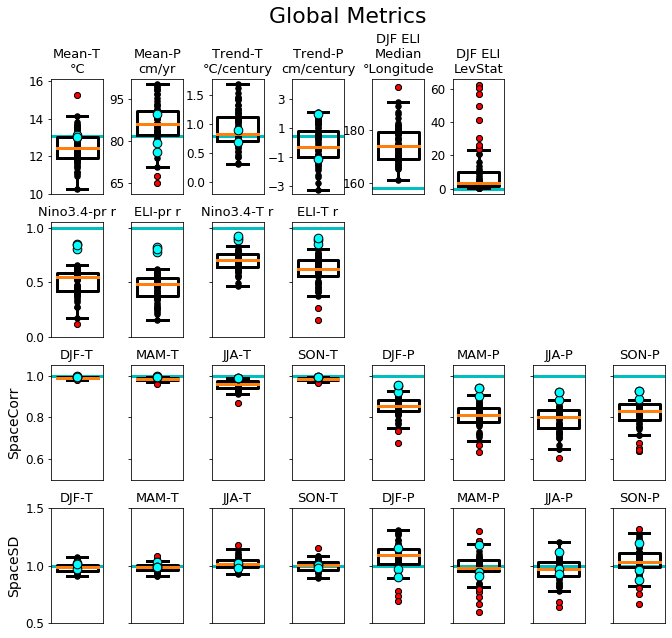

In [97]:
tlinst = 'c-'
modmet_ensm = np.nanmean(modmet,axis=2)
mask = ~np.isnan(modmet_ensm)
filty = [d[m] for d, m in zip(modmet_ensm.T, mask.T)]
i=0
xran = [.05,1.95]
fig,axs = plt.subplots(4,8,figsize=(11,10),sharex='all')
for ax in axs.flat:
    if i in [6,7,12,13,14,15]:
        ax.remove()
        i+=1
        continue
    if i<=5:
        ax.boxplot(filty[i],whiskerprops=dict(linestyle='-',linewidth=3),
                                    capprops=dict(linewidth=3),
                                    boxprops=dict(linewidth=3),
                                    medianprops=dict(linewidth=3),
                                    flierprops=dict(marker='o',markerfacecolor='r',markeredgecolor='k',linestyle='none'),
                                    widths=1.5)
    elif (i>=8) and (i<=11):
        ax.boxplot(filty[i-2],whiskerprops=dict(linestyle='-',linewidth=3),
                                    capprops=dict(linewidth=3),
                                    boxprops=dict(linewidth=3),
                                    medianprops=dict(linewidth=3),
                                    flierprops=dict(marker='o',markerfacecolor='r',markeredgecolor='k',linestyle='none'),
                                    widths=1.5)
    else:
        ax.boxplot(filty[i-6],whiskerprops=dict(linestyle='-',linewidth=3),
                                    capprops=dict(linewidth=3),
                                    boxprops=dict(linewidth=3),
                                    medianprops=dict(linewidth=3),
                                    flierprops=dict(marker='o',markerfacecolor='r',markeredgecolor='k',linestyle='none'),
                                    widths=1.5)

    if i == 0:
        ax.plot(xran,[meanto.item(),meanto.item()],tlinst,linewidth=3,zorder=-1)
        ax.set_ylim([10.,16.1])
        ax.set_yticks([10,12,14,16])
    elif i == 1:
        ax.plot(xran,[meanpo.item(),meanpo.item()],tlinst,linewidth=3,zorder=-1)
        
        ax.set_ylim([61.,102.28])
        ax.set_yticks([65,80,95])
        #ax.yaxis.get_majorticklabels()[3].set_x(.065)
        #ax.yaxis.set_label_coords(-.27, .5)
    elif i == 2:
        ax.plot(xran,[ttrendo,ttrendo],tlinst,linewidth=3,zorder=-1)
        #ax.set_ylabel('°C/century',fontsize=14)
        ax.set_ylim([-0.2,1.77])
        ax.set_yticks([-0.,0.5,1,1.5])
    elif i == 3:
        ax.plot(xran,[ptrendo,ptrendo],tlinst,linewidth=3,zorder=-1)
        #ax.set_ylabel('cm/century', fontsize=14)
        ax.set_ylim([-3.5,4.4])
        ax.set_yticks([-3,-1,1,3])
        ax.yaxis.set_label_coords(-.27, .5)
    elif i == 4:
        ax.plot(xran,[np.median(oseasvars['CRU']['DJF']['eli']),
                           np.median(oseasvars['CRU']['DJF']['eli'])],tlinst,zorder=-1,linewidth=3)
        #ax.set_ylabel('° Longitude',fontsize=20)
        # ax.set_ylim([-7.,11.82])
        # ax.set_yticks([-5,0,5,10])
    elif i == 5:
        ax.plot(xran,[0,0],tlinst,zorder=-1,linewidth=3)
        ax.set_ylim([-3,66])
    elif i in (np.arange(8,12)):
        ax.plot(xran,[1,1],tlinst,linewidth=3,zorder=-1)
        ax.set_ylim([0.0,1.05])
        if i>8:
            ax.set_yticklabels([])
    elif i in (np.arange(16,24)):
        ax.plot(xran,[1,1],tlinst,linewidth=3,zorder=-1)
        ax.set_ylim([0.5,1.05])
        if i>16:
            ax.set_yticklabels([])
        if i==16:
            ax.set_ylabel('SpaceCorr',fontsize=14)
    elif i in (np.arange(24,32)):
        ax.plot(xran,[1,1],tlinst,linewidth=3,zorder=-1)
        ax.set_ylim([0.5,1.5])
        ax.set_yticks([0.5,1,1.5])
        if i>24:
            ax.set_yticklabels([])
        if i==24:
            ax.set_ylabel('SpaceSD',fontsize=14)
    else:
        ax.plot(xran,[1,1],tlinst,linewidth=3,zorder=-1)
    #===================================================
    
    if i<=5:
        ax.scatter(np.ones(modmet_ensm.shape[0]),modmet_ensm[:,i],c='k',s=30)
    elif (i>=8) and (i<=11):
        ax.scatter(np.ones(modmet_ensm.shape[0]),modmet_ensm[:,i-2],c='k',s=30)
    else:
        ax.scatter(np.ones(modmet_ensm.shape[0]),modmet_ensm[:,i-6],c='k',s=30)
        
    #===================================================
    
    if i <= 5:
        ax.scatter(np.ones(obsmet.shape[0]),obsmet[:,i],c='cyan',s=75,edgecolors='k',zorder=5)
    elif (i>=8) and (i<=11):
        ax.scatter(np.ones(obsmet.shape[0]),obsmet[:,i-2],c='cyan',s=75,edgecolors='k',zorder=5)
    else:
        ax.scatter(np.ones(obsmet.shape[0]),obsmet[:,i-6],c='cyan',s=75,edgecolors='k',zorder=5)
        
    #===================================================
    
    metric_title_size = 13
    if i<=5:
        ax.set_title(metric_titles[i],fontsize=metric_title_size)
        
    elif (i>=8) and (i<=11):
        ax.set_title(metric_titles[i-2],fontsize=metric_title_size)
    else:
        ax.set_title(metric_titles[i-6],fontsize=metric_title_size)
    ax.set_xlim(xran[0],xran[1])
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=12)
    i += 1
fig.subplots_adjust(left=0.125,right=0.9,wspace=0.55,hspace=0.25)
plt.suptitle('Global Metrics',fontsize=22,y=0.98)
plt.savefig('/glade/u/home/nlybarger/CMIP6_1900-2014.global.metricarray.png',dpi=450,bbox_inches='tight',facecolor='w')
#plt.close()